<a href="https://colab.research.google.com/github/VyomSawhney/Brain-Tumor-MRI-Classification/blob/main/Brain_Cancer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brain Cancer Convolutional Neural Network - by Vyom Sawhney

##Importing Kaggle Dataset

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas


# Username and Key can be found in JSON downloaded at https://www.kaggle.com/settings under "Create New Token" button
od.download(
    "https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vyomsawhney
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset


100%|██████████| 144M/144M [00:00<00:00, 1.21GB/s]

In [3]:
import os
import shutil

base_path = "/content"

src = os.path.join(base_path, "brain-cancer-mri-dataset", "Brain_Cancer raw MRI data", "Brain_Cancer")
dst = os.path.join(base_path, "brain_cancer")
shutil.move(src, dst)

shutil.rmtree(os.path.join(base_path, "brain-cancer-mri-dataset"))

print("Dataset folder cleaned and ready.")

Dataset folder cleaned and ready.


##Process Data

In [4]:
import torch
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [5]:
# Transformation/Augmentations for training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Resizing but no augmentation for test dataset
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="/content/brain_cancer", transform=base_transform)

In [6]:
# 70% Train, 15% val and 15% Test
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Set transformations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = base_transform
test_dataset.dataset.transform = base_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##ResNet18 Transfer

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace the FC layer allowing to train the model to the 3 classes in our dataset
num_classes = 3  # Brain_Glioma, Brain_Menin, Brain_Tumor
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [10]:
# Number of training iteration, 1 iteration is forward->loss->backwards->update
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = train_loss / total
    accuracy = correct / total * 100

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Accuracy: {accuracy:.2f}%")


Epoch 1/10 | Train Loss: 0.4750 | Train Accuracy: 83.20%
Epoch 2/10 | Train Loss: 0.1710 | Train Accuracy: 95.40%
Epoch 3/10 | Train Loss: 0.1018 | Train Accuracy: 97.38%
Epoch 4/10 | Train Loss: 0.0577 | Train Accuracy: 98.75%
Epoch 5/10 | Train Loss: 0.0423 | Train Accuracy: 99.32%
Epoch 6/10 | Train Loss: 0.0258 | Train Accuracy: 99.60%
Epoch 7/10 | Train Loss: 0.0172 | Train Accuracy: 99.88%
Epoch 8/10 | Train Loss: 0.0135 | Train Accuracy: 99.91%
Epoch 9/10 | Train Loss: 0.0095 | Train Accuracy: 99.98%
Epoch 10/10 | Train Loss: 0.0105 | Train Accuracy: 99.86%


##Results and Data Visualization

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_on_test(model, loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Classification Report:

              precision    recall  f1-score   support

brain_glioma       1.00      0.99      1.00       305
 brain_menin       0.98      0.98      0.98       313
 brain_tumor       0.98      0.98      0.98       291

    accuracy                           0.98       909
   macro avg       0.98      0.98      0.98       909
weighted avg       0.98      0.98      0.98       909



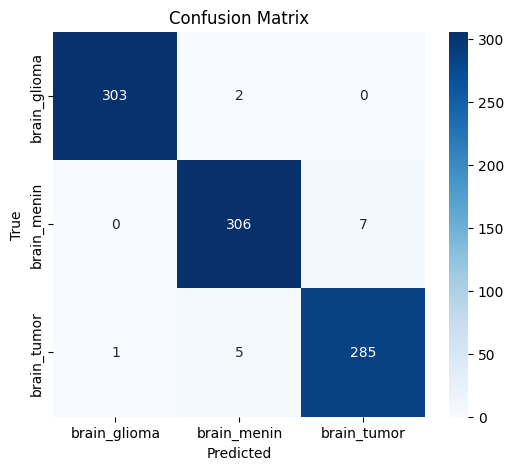

In [14]:
class_names = dataset.classes  # ['brain_glioma', 'brain_menin', 'brain_tumor']
evaluate_on_test(model, test_loader, class_names)

In [15]:
# Courteous of Stepan Ulyanin (https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82)
import cv2
import numpy as np

def generate_gradcam(model, image_tensor, target_class=None):
    model.eval()

    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    final_conv = model.layer4[-1].conv2
    handle_f = final_conv.register_forward_hook(forward_hook)
    handle_b = final_conv.register_backward_hook(backward_hook)

    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)

    if target_class is None:
        target_class = output.argmax().item()

    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    grad = gradients[0].cpu().detach().numpy()[0]
    act = activations[0].cpu().detach().numpy()[0]

    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= np.max(cam)

    handle_f.remove()
    handle_b.remove()

    return cam

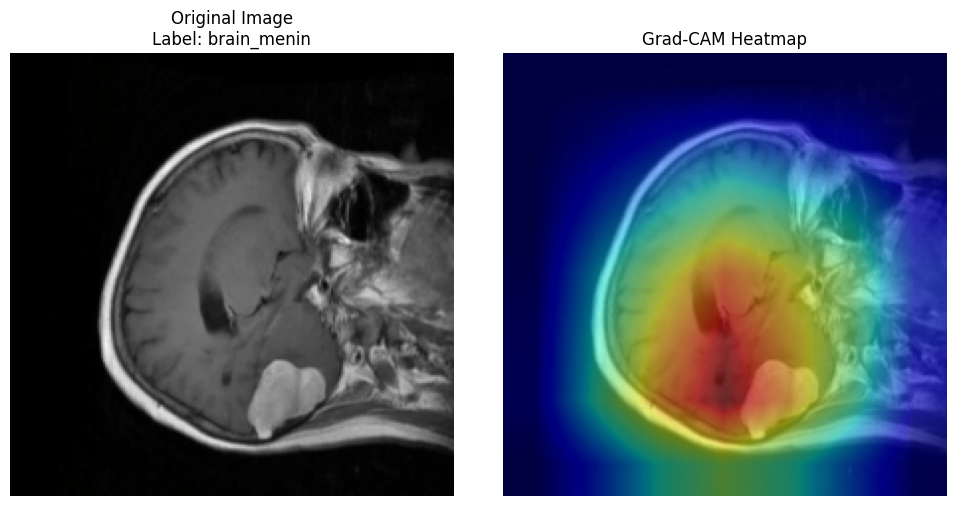

In [25]:
image, label = test_dataset[57]
cam = generate_gradcam(model, image)

img = image.permute(1, 2, 0).cpu().numpy()
img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axs[0].imshow(img)
axs[0].set_title(f"Original Image\nLabel: {class_names[label]}")
axs[0].axis('off')

# Grad-CAM overlay
axs[1].imshow(img)
axs[1].imshow(cam, cmap='jet', alpha=0.5)
axs[1].set_title("Grad-CAM Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()
